In [ ]:
!pip install mlflow boto3 awscli

In [ ]:
import mlflow
mlflow.set_tracking_uri("http://ec2-98-89-47-151.compute-1.amazonaws.com:5000/")


In [ ]:
mlflow.set_experiment("Exp 4 - Handling Imbalanced Data")

<Experiment: artifact_location='s3://mlflow-s3-bucket-25/611617304609682185', creation_time=1766255745620, experiment_id='611617304609682185', last_update_time=1766255745620, lifecycle_stage='active', name='Exp 4 - Handling Imbalanced Data', tags={}>

In [ ]:
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import mlflow
import mlflow.sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os

In [ ]:
df = pd.read_csv('reddit_preprocessing.csv').dropna(subset=['clean_comment'])
df.shape

(36662, 2)

Testing different imbalance handling methods...


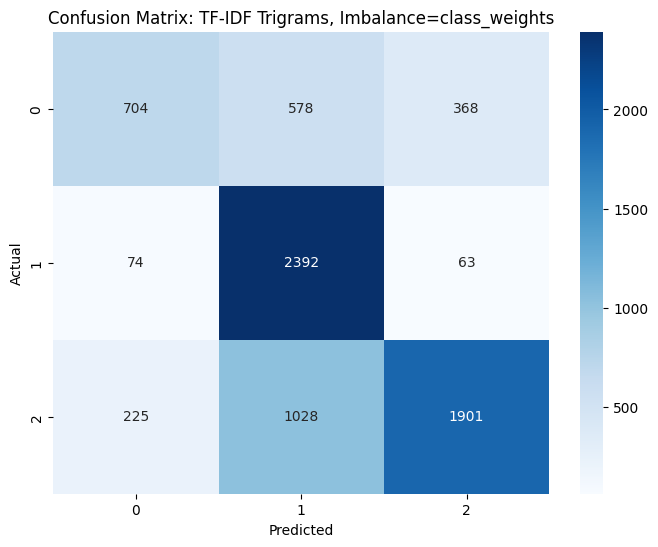

✓ class_weights   - Accuracy: 0.6814


2025/12/22 14:31:22 INFO mlflow.tracking._tracking_service.client: 🏃 View run Imbalance_class_weights_RandomForest_TFIDF_Trigrams at: http://ec2-98-89-47-151.compute-1.amazonaws.com:5000/#/experiments/611617304609682185/runs/9880fa4e7ffd4a17a7ad2047b0161bb1.
2025/12/22 14:31:22 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://ec2-98-89-47-151.compute-1.amazonaws.com:5000/#/experiments/611617304609682185.


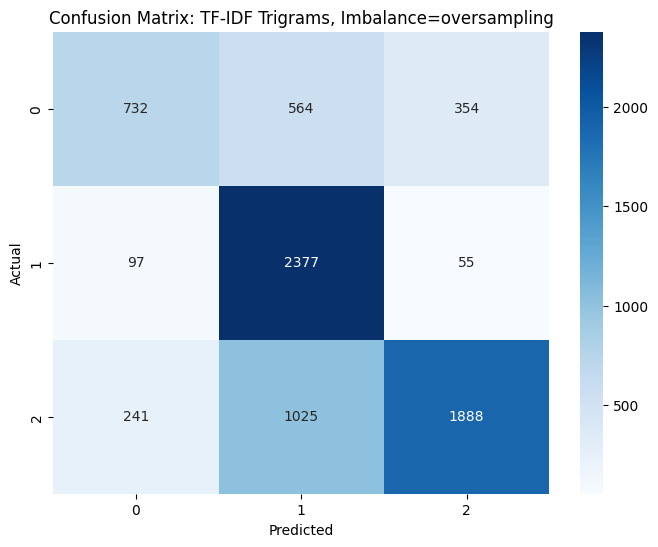

✓ oversampling    - Accuracy: 0.6814


2025/12/22 14:31:52 INFO mlflow.tracking._tracking_service.client: 🏃 View run Imbalance_oversampling_RandomForest_TFIDF_Trigrams at: http://ec2-98-89-47-151.compute-1.amazonaws.com:5000/#/experiments/611617304609682185/runs/59d0e121916049778bdb25a50750214d.
2025/12/22 14:31:52 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://ec2-98-89-47-151.compute-1.amazonaws.com:5000/#/experiments/611617304609682185.


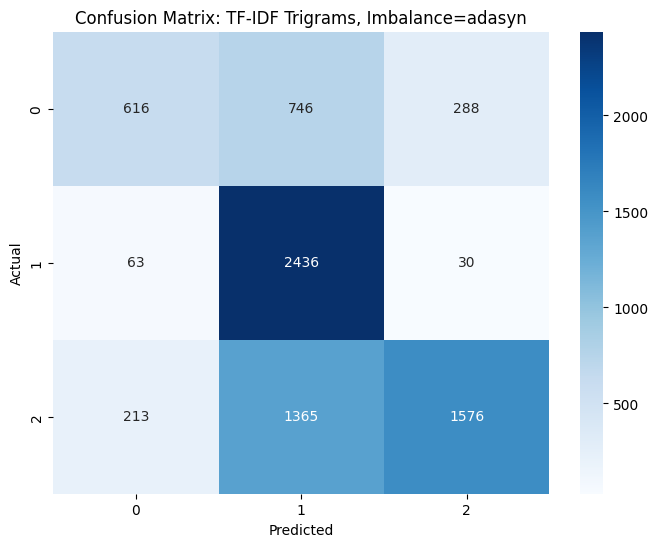

✓ adasyn          - Accuracy: 0.6311


2025/12/22 14:32:33 INFO mlflow.tracking._tracking_service.client: 🏃 View run Imbalance_adasyn_RandomForest_TFIDF_Trigrams at: http://ec2-98-89-47-151.compute-1.amazonaws.com:5000/#/experiments/611617304609682185/runs/09a511b02ad14fa0a5452bef5bd90d8d.
2025/12/22 14:32:33 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://ec2-98-89-47-151.compute-1.amazonaws.com:5000/#/experiments/611617304609682185.


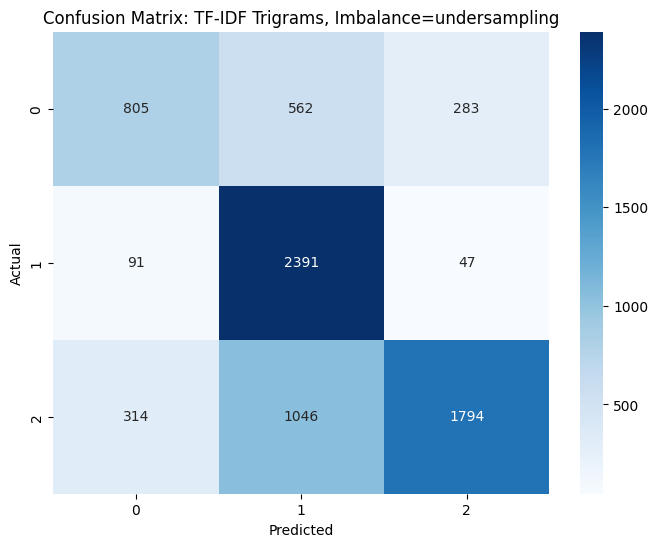

✓ undersampling   - Accuracy: 0.6805


2025/12/22 14:33:00 INFO mlflow.tracking._tracking_service.client: 🏃 View run Imbalance_undersampling_RandomForest_TFIDF_Trigrams at: http://ec2-98-89-47-151.compute-1.amazonaws.com:5000/#/experiments/611617304609682185/runs/c84eccb82e7245b59836f7ec34a1bd26.
2025/12/22 14:33:00 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://ec2-98-89-47-151.compute-1.amazonaws.com:5000/#/experiments/611617304609682185.


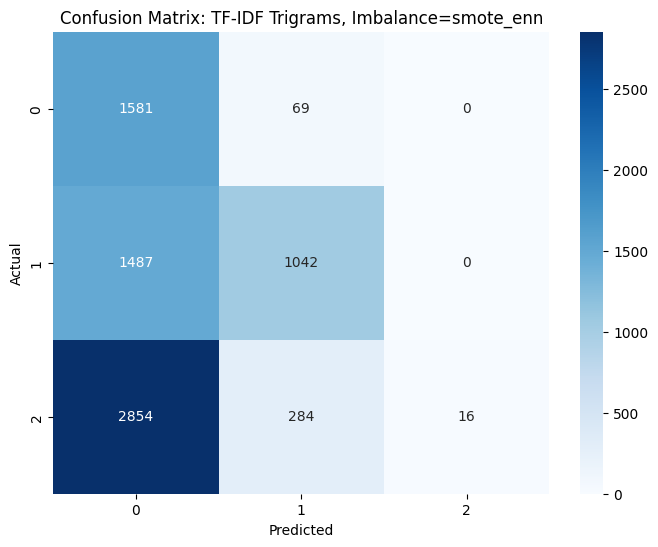

✓ smote_enn       - Accuracy: 0.3599


2025/12/22 14:33:58 INFO mlflow.tracking._tracking_service.client: 🏃 View run Imbalance_smote_enn_RandomForest_TFIDF_Trigrams at: http://ec2-98-89-47-151.compute-1.amazonaws.com:5000/#/experiments/611617304609682185/runs/32d227f6e2ca4e5496512312d8fd3a9b.
2025/12/22 14:33:58 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://ec2-98-89-47-151.compute-1.amazonaws.com:5000/#/experiments/611617304609682185.


✓ All experiments completed!
✓ View results: http://ec2-98-89-47-151.compute-1.amazonaws.com:5000/


In [ ]:
# Function to run the experiment
def run_imbalanced_experiment(imbalance_method):
    ngram_range = (1, 3)  # Trigram setting
    max_features = 10000  # Set max_features to 1000 for TF-IDF

    # Train-test split before vectorization and resampling
    X_train, X_test, y_train, y_test = train_test_split(df['clean_comment'], df['category'], test_size=0.2, random_state=42, stratify=df['category'])

    # Vectorization using TF-IDF, fit on training data only
    vectorizer = TfidfVectorizer(ngram_range=ngram_range, max_features=max_features)
    X_train_vec = vectorizer.fit_transform(X_train)  # Fit on training data
    X_test_vec = vectorizer.transform(X_test)  # Transform test data

    # Handle class imbalance based on the selected method (only applied to the training set)
    if imbalance_method == 'class_weights':
        # Use class_weight in Random Forest
        class_weight = 'balanced'
    else:
        class_weight = None  # Do not apply class_weight if using resampling

        # Resampling Techniques (only apply to the training set)
        if imbalance_method == 'oversampling':
            smote = SMOTE(random_state=42)
            X_train_vec, y_train = smote.fit_resample(X_train_vec, y_train)
        elif imbalance_method == 'adasyn':
            adasyn = ADASYN(random_state=42)
            X_train_vec, y_train = adasyn.fit_resample(X_train_vec, y_train)
        elif imbalance_method == 'undersampling':
            rus = RandomUnderSampler(random_state=42)
            X_train_vec, y_train = rus.fit_resample(X_train_vec, y_train)
        elif imbalance_method == 'smote_enn':
            smote_enn = SMOTEENN(random_state=42)
            X_train_vec, y_train = smote_enn.fit_resample(X_train_vec, y_train)

    # Define and train a Random Forest model
    with mlflow.start_run() as run:
        # Set tags for the experiment and run
        mlflow.set_tag("mlflow.runName", f"Imbalance_{imbalance_method}_RandomForest_TFIDF_Trigrams")
        mlflow.set_tag("experiment_type", "imbalance_handling")
        mlflow.set_tag("model_type", "RandomForestClassifier")

        # Add a description
        mlflow.set_tag("description", f"RandomForest with TF-IDF Trigrams, imbalance handling method={imbalance_method}")

        # Log vectorizer parameters
        mlflow.log_param("vectorizer_type", "TF-IDF")
        mlflow.log_param("ngram_range", ngram_range)
        mlflow.log_param("vectorizer_max_features", max_features)

        # Log Random Forest parameters
        n_estimators = 200
        max_depth = 15

        mlflow.log_param("n_estimators", n_estimators)
        mlflow.log_param("max_depth", max_depth)
        mlflow.log_param("imbalance_method", imbalance_method)

        # Initialize and train the model
        model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=42, class_weight=class_weight)
        model.fit(X_train_vec, y_train)

        # Make predictions and log metrics
        y_pred = model.predict(X_test_vec)

        # Log accuracy
        accuracy = accuracy_score(y_test, y_pred)
        mlflow.log_metric("accuracy", accuracy)

        # Log classification report
        classification_rep = classification_report(y_test, y_pred, output_dict=True)
        for label, metrics in classification_rep.items():
            if isinstance(metrics, dict):
                for metric, value in metrics.items():
                    mlflow.log_metric(f"{label}_{metric}", value)

        # Display confusion matrix in notebook (not logged to avoid S3 errors)
        conf_matrix = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title(f"Confusion Matrix: TF-IDF Trigrams, Imbalance={imbalance_method}")
        plt.show()  # Display in notebook
        plt.close()  # Clean up
        
        # Print results
        print(f"✓ {imbalance_method:15s} - Accuracy: {accuracy:.4f}")

# Run experiments for different imbalance methods
imbalance_methods = ['class_weights', 'oversampling', 'adasyn', 'undersampling', 'smote_enn']

print("Testing different imbalance handling methods...")
print("=" * 60)

for method in imbalance_methods:
    run_imbalanced_experiment(method)

print("=" * 60)
print("✓ All experiments completed!")
print(f"✓ View results: http://ec2-98-89-47-151.compute-1.amazonaws.com:5000/")
